In [1]:
import os
import cv2
import sys
import ujson
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, precision=4)

## CARLA dataset

The dataset structure is as follows:
- Train
    - route1/
        - depth/
            - 0000.png
        - label_raw/
            - 0000.json
        - lidar/
            - 0000.npy
        - measurements/
            - 0000.json
        - rgb/
            - 0000.png
        - semantics/
            - 0000.png
        - topdown/
            - 0000.png
    - route2/
    
- Each route contains sequence of sensor data, where the ego vehicle traverses from a start location to end location, while interacting with other agents in the environment
- There are different **Towns**, each with its own layout in CARLA environment
- The routes are also categorised by **Scenarios**, where a specific set of events occur. Example: Ego vehicle trying to make Right turn, at an intersection with crossing traffic

In [2]:
from config import GlobalConfig
from data import CARLA_Data

root_dir = '/home/surya/Downloads/transfuser-2022/data/train/'
config = GlobalConfig()
train_set = CARLA_Data(root=root_dir, config=config)
print(f"There are {len(train_set)} samples in training set")

# we'll look at data points within 1 sample
index = 0

100%|██████████| 20/20 [00:00<00:00, 94.42it/s]
There are 1954 samples in training set


### RGB image

(160, 960, 3)


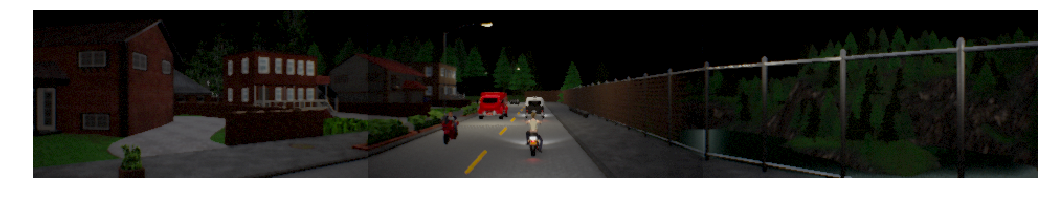

In [3]:
# load RGB image, scale to resolution, change to (C, H, W) format
rgb_image = cv2.imread(str(train_set.images[index], encoding='utf-8'), cv2.IMREAD_COLOR)
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
print(rgb_image.shape)

plt.figure(figsize=(18,8))
plt.imshow(rgb_image)
plt.axis('off');

We'll define a function to crop the image, which will be useful for loading other image type data

In [4]:
def crop_image_cv2(image, crop=(128, 640), channelFirst=False):
    width = image.shape[1]
    height = image.shape[0]
    crop_h, crop_w = crop
    start_y = height // 2 - crop_h // 2
    start_x = width // 2 - crop_w // 2
    cropped_image = image[start_y:start_y + crop_h, start_x:start_x + crop_w]
    if channelFirst:
        cropped_image = np.transpose(cropped_image, (2, 0, 1))
    return cropped_image

(160, 704, 3)


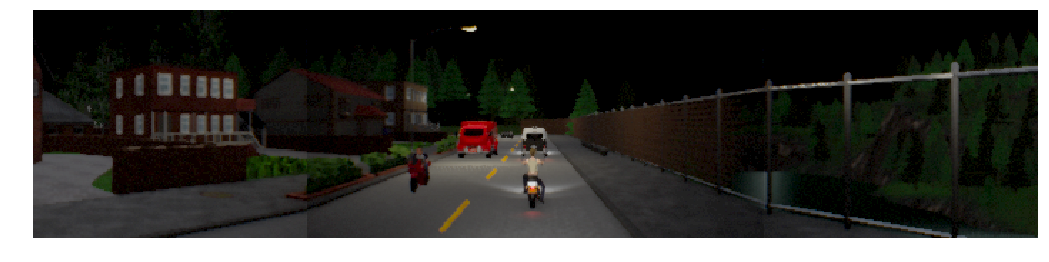

In [5]:
rgb_image = crop_image_cv2(rgb_image, crop=config.img_resolution)
print(rgb_image.shape)

plt.figure(figsize=(18,8))
plt.imshow(rgb_image)
plt.axis('off');

### BEV image

Next, we'll load a BEV image, which is stored as an encoded image. The file is encoded to contain different classes. We crop the BEV image to 32m x 32m grid

bev_array shape = (500, 500, 3), Unique values are [  0   8  16  24  32  40  48  56  64  96 112 120 128 136 160 176 184 192
 200 224 240 248]
Decoded bev shape = (2, 500, 500)
Cropped bev shape = (160, 160), unique values = [0 1 2], dtype = int64


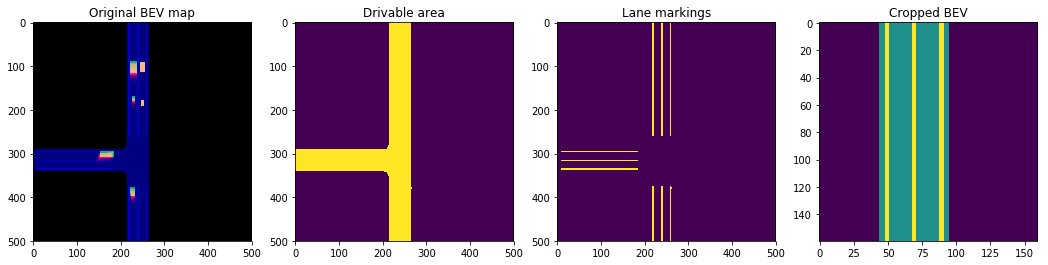

In [6]:
# BEV image -> load, decode, crop
# BEV image is multi class map containing 3 classes
# drivable area, lane markings, unkown (black)
bev_array = cv2.imread(str(train_set.bevs[index], encoding='utf-8'), cv2.IMREAD_UNCHANGED)
bev_array = cv2.cvtColor(bev_array, cv2.COLOR_BGR2RGB)
print(f"bev_array shape = {bev_array.shape}, Unique values are {np.unique(bev_array)}")
bev_array = np.moveaxis(bev_array, -1, 0)

# Crop portion of BEV image, visible to ego vehicle 
from data import decode_pil_to_npy, load_crop_bev_npy
loaded_bevs = decode_pil_to_npy(bev_array).astype(np.uint8)
bev = load_crop_bev_npy(loaded_bevs, degree=0)
print(f"Decoded bev shape = {loaded_bevs.shape}")
print(f"Cropped bev shape = {bev.shape}, unique values = {np.unique(bev)}, dtype = {bev.dtype}")

# plot images
fig, ax  = plt.subplots(1,4, figsize=(18,6))
ax[0].imshow(np.moveaxis(bev_array, 0, 2));
ax[0].set_title("Original BEV map");
ax[1].imshow(loaded_bevs[0]);
ax[1].set_title("Drivable area");
ax[2].imshow(loaded_bevs[1]);
ax[2].set_title("Lane markings");
ax[3].imshow(bev);
ax[3].set_title("Cropped BEV");

### Depth image

depth_image shape = (160, 704), dtype = float64


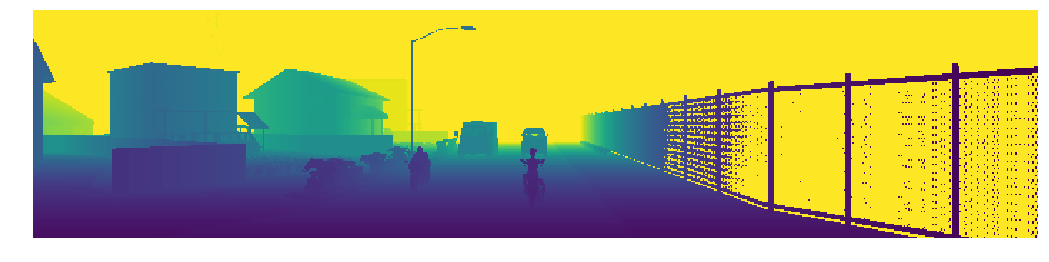

In [7]:
# Depth image
depth_image = cv2.imread(str(train_set.depths[index], encoding='utf-8'))
depth_image = cv2.cvtColor(depth_image, cv2.COLOR_BGR2RGB)
depth_image = crop_image_cv2(depth_image, crop=config.img_resolution, channelFirst=True)

# depth sensor data parsing logic from CARLA
def get_depth(data):
    data = np.transpose(data, (1,2,0))
    data = data.astype(np.float32)
    normalized = np.dot(data, [65536.0, 256.0, 1.0]) 
    normalized /=  (256 * 256 * 256 - 1)
    
    # CARLA gets ground truth depth map from Unreal engine for 1km
    # we'll clip to 50 meters to keep it realistic
    normalized = np.clip(normalized, a_min=0.0, a_max=0.05)
    normalized = normalized * 20.0 # Rescale map to lie in [0,1]
    return normalized


depth_image = get_depth(depth_image)
print(f"depth_image shape = {depth_image.shape}, dtype = {depth_image.dtype}")
plt.figure(figsize=(18, 8))
plt.imshow(depth_image);
plt.axis('off');

### Segmentation image

semantic_image shape = (160, 704), unique_values = [0 1 2 4 5 6]


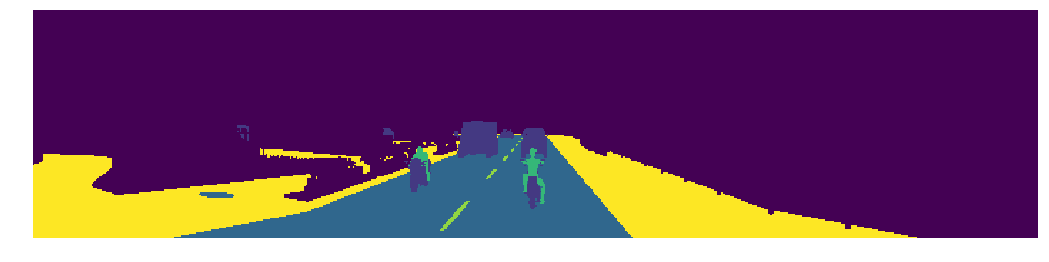

In [8]:
# Semantic segmented image
semantic_image = cv2.imread(str(train_set.semantics[index], encoding='utf-8'), cv2.IMREAD_UNCHANGED)
semantic_image = train_set.converter[crop_image_cv2(semantic_image, crop=train_set.img_resolution)]
print(f"semantic_image shape = {semantic_image.shape}, unique_values = {np.unique(semantic_image.flatten())}")

plt.figure(figsize=(18, 8))
plt.imshow(semantic_image);
plt.axis('off');

### Ego vehicle measurement

In [9]:
# Ego vehicle measurements
with open(str(train_set.measurements[index], encoding='utf-8'), 'r') as f1:
    measurements = ujson.load(f1)
    
from pprint import pprint
pprint(measurements)

{'angle': 1.7476113454154878e-05,
 'brake': False,
 'command': 4,
 'ego_matrix': [[-0.9999999403953552,
                 -0.00032606918830424547,
                 1.1926136949114152e-06,
                 77.37936401367188],
                [0.00032606918830424547,
                 -0.9999999403953552,
                 1.597508003214898e-06,
                 -2.0416176319122314],
                [1.1920927818209748e-06,
                 1.597896812199906e-06,
                 1.0,
                 0.033258818089962006],
                [0.0, 0.0, 0.0, 1.0]],
 'junction': False,
 'light_hazard': False,
 'speed': 2.772401933322306e-07,
 'steer': 0.0,
 'stop_sign_hazard': False,
 'target_speed': 4.0,
 'theta': 4.712062835693359,
 'throttle': 0.75,
 'vehicle_hazard': [False,
                    False,
                    False,
                    False,
                    False,
                    False,
                    False,
                    False,
                    False,
   

### Goal location (Command points)

In [10]:
# convert x_command, y_command to ego vehicle coordinates
ego_theta = measurements['theta']
ego_x = measurements['x']
ego_y = measurements['y']
x_command = measurements['x_command']
y_command = measurements['y_command']

R = np.array([
    [np.cos(np.pi/2+ego_theta), -np.sin(np.pi/2+ego_theta)],
    [np.sin(np.pi/2+ego_theta),  np.cos(np.pi/2+ego_theta)]
    ])
local_command_point = np.array([x_command-ego_x, y_command-ego_y])
local_command_point = R.T.dot(local_command_point)

print(f"ego_x = {ego_x : .3f}, ego_y = {ego_y: .3f}, x_command = {x_command: .3f}, y_command = {y_command: .3f}")
print(f"local_command_point = {local_command_point}")

ego_x =  2.042, ego_y =  77.379, x_command =  2.025, y_command =  26.379
local_command_point = [  0. -51.]


Instead of directly feeding in the target point, we'll plot the destination coordintes in BEV frame and provide it as input

Target point in lidar shape = (1, 256, 256)


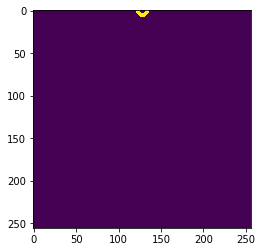

In [11]:
from data import draw_target_point
tgt_pt_in_lidar = draw_target_point(local_command_point)
print(f"Target point in lidar shape = {tgt_pt_in_lidar.shape}")
plt.imshow(tgt_pt_in_lidar[0]);

### Lidar Point Cloud

In [12]:
# plot library imports
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [13]:
HEIGHT_FROM_GROUND = 0.25
CAMERA_HEIGHT = 2.3   # camera height in meters
LIDAR_HEIGHT =  2.5    # LIDAR height in meters
COORDINATE_AXIS = ['x', 'y', 'z']

In [15]:
def get_scatter3d_plot(x,y,z, mode='lines', marker_size=1, color=None, opacity=1, colorscale=None, **kwargs):
    return go.Scatter3d(x=x, y=y, z=z, mode=mode, hoverinfo='skip',showlegend=False, 
                        marker = dict(size=marker_size, color=color, opacity=opacity, colorscale=colorscale), **kwargs)

def plot_pc_data3d(x,y,z, apply_color_gradient=True, color=None, marker_size=1, colorscale=None, **kwargs):
    if apply_color_gradient:
        color = np.sqrt(x**2 + y **2 + z **2)
    return get_scatter3d_plot(x,y,z, mode='markers', color=color, colorscale=colorscale, marker_size=marker_size, **kwargs)

In [19]:
def get_lidar3d_plots(points, pc_kwargs={}, gt_box_corners=None, gt_box_colors=None, 
                      pred_box_corners=None, pred_box_colors=None, **kwargs):
    lidar3d_plots = []
    #  point cloud data
    lidar3d_plots.append(plot_pc_data3d(x=points[:,0], y=points[:,1], z=points[:,2], **pc_kwargs))      
    # gt bounding boxes
    if((gt_box_corners is not None) and (gt_box_colors is not None)):
        lidar3d_plots.extend(plot_bboxes_3d(gt_box_corners, gt_box_colors, **kwargs))  
    # predicted bounding boxes
    if((pred_box_corners is not None) and (pred_box_colors is not None)):
        lidar3d_plots.extend(plot_bboxes_3d(pred_box_corners, pred_box_colors, **kwargs))  
    return lidar3d_plots

Lidar point cloud shape = (22133, 4)
below shape = (15581, 4), above shape = (6552, 4)


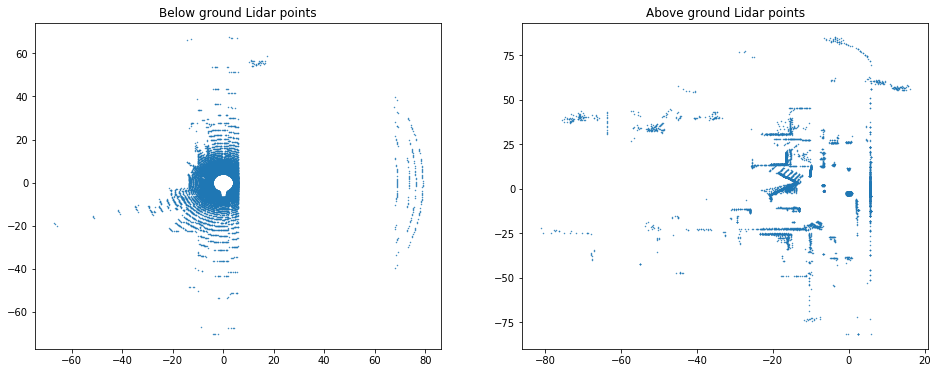

In [37]:
# load point cloud (XYZI), flip y-axis, compute Lidar BEV features
lidars_pc = np.load(str(train_set.lidars[index], encoding='utf-8'), allow_pickle=True)[1]
lidars_pc[:, 1] *= -1
print(f"Lidar point cloud shape = {lidars_pc.shape}")

# filter points above and below ground
below = lidars_pc[lidars_pc[...,2]<=-2.3]
above = lidars_pc[lidars_pc[...,2]>-2.3]
print(f"below shape = {below.shape}, above shape = {above.shape}")

fig, ax  = plt.subplots(1,2, figsize=(16,6))
ax[0].scatter(-below[:,0], -below[:,1], s = 0.2);
ax[0].set_title("Below ground Lidar points");
ax[1].scatter(-above[:,0], -above[:,1], s = 0.2);
ax[1].set_title("Above ground Lidar points");

In [68]:
temp = lidars_pc
temp[..., 1] *= -1
temp = temp[:, [1,0,2]]
temp = temp[(temp[..., 0] > 0) & (np.abs(temp[..., 1]) < 30) & (temp[..., 2] > -2.4)]
print(temp.shape)

(3593, 3)


In [98]:
PCD_CAM_VIEW = dict(
            up=dict(x=0, y=0, z=1),
            eye=dict(x=-1, y=0, z=0.2)
    )

PCD_SCENE=dict(
        xaxis=dict(visible=False),#,range=[-30,30]),
        yaxis=dict(visible=False),#,range=[-100,0]),
        zaxis=dict(visible=False,),
        aspectmode='manual', #this string can be 'data', 'cube', 'auto', 'manual'
        aspectratio=dict(x=1, y=1, z=0.2),
)

# Function plots point cloud data along with ground truth boxes to the scene
lidar_3d_plots = get_lidar3d_plots(temp, pc_kwargs=dict(colorscale='viridis', marker_size=1))
layout = dict(template="plotly_dark", scene=PCD_SCENE, scene_camera = PCD_CAM_VIEW, title="POINT CLOUD VISUALIZATION")
fig = go.Figure(data=lidar_3d_plots, layout=layout)
fig.show()

The lidar point cloud from simulator covers 360 degree for larger range (distance). We'll crop the points within BEV range (32m x32m)

In [ ]:
# generate BEV histogram featuers, separately for
# above ground and below ground points
from data import lidar_to_histogram_features
lidars_pc = lidar_to_histogram_features(lidars_pc)
print(f"Lidar histogram feature shape = {lidars_pc.shape}")

fig, ax  = plt.subplots(1,2, figsize=(16,6))
ax[0].imshow(lidars_pc[0]);
ax[0].set_title("BEV Histogram feature for Above ground points");
ax[1].imshow(lidars_pc[1]);
ax[1].set_title("BEV Histogram feature for Below ground points");

Apart from sensor inputs, we can consider Bounding boxes of objects in environment, which can be used as an auxiliary target, to improve training performance

### BEV Bounding Boxes

Bounding boxes are represented by 2D rectangles, with **[centre x, centre y, width, height, yaw]** representation. Additionally, we add the brake and speed information for each agent

In [21]:
# Because the strings are stored as numpy byte objects we need to convert them back to utf-8 strings
# Since we also load labels for future timesteps, we load and store them separately
labels = []
for i in range(train_set.seq_len + train_set.pred_len):
    with open(str(train_set.labels[index][i], encoding='utf-8'), 'r') as f2:
        labels_i = ujson.load(f2)
    labels.append(labels_i)
    
from pprint import pprint
pprint(labels[0][0])

{'brake': 0.0,
 'class': 'Car',
 'distance': -1,
 'ego_matrix': [[-0.9999999403953552,
                 -0.00032606918830424547,
                 1.1926136949114152e-06,
                 77.37936401367188],
                [0.00032606918830424547,
                 -0.9999999403953552,
                 1.597508003214898e-06,
                 -2.0416176319122314],
                [1.1920927818209748e-06,
                 1.597896812199906e-06,
                 1.0,
                 0.033258818089962006],
                [0.0, 0.0, 0.0, 1.0]],
 'extent': [1.5107464790344238, 4.901683330535889, 2.128324270248413],
 'id': 432,
 'num_points': -1,
 'position': [-1.3, 0.0, -2.5],
 'speed': 2.772401933322306e-07,
 'yaw': 0}


Here `ego_matrix` contains the agent position in Global CARLA coordinates. `extent` is 3D Bounding box information

In [22]:
# Bounding boxes of objects within BEV FOV(32m x 32m)
# considering only current frame objects
from data import parse_labels
bboxes = parse_labels(labels[0])
label = np.array(list(bboxes.values()))
print(f"Label shape = {label.shape}")
print(label)

Label shape = (4, 7)
[[ 95.5467 144.3944   6.4206  16.2668  -3.1413   0.       0.    ]
 [127.381  162.2656   6.1094  18.8459  -6.2829   0.0001   0.    ]
 [ 95.5837  30.8745  20.9166  41.6307  -3.1413  -0.       0.    ]
 [127.4238  30.8849  16.5545  35.8435   0.0003  -0.       0.    ]]


### Future Ego waypoints

ego_waypoints shape = (4, 2)
[[-1.3    -0.    ]
 [-1.3    -0.    ]
 [-0.4892  0.    ]
 [ 1.5503 -0.    ]]


Text(0.5, 1.0, 'Ego vehicle future waypoints')

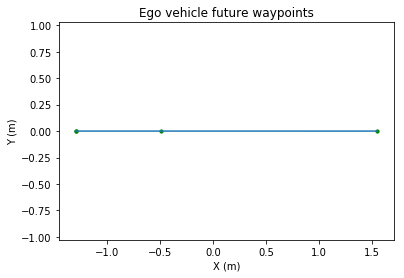

In [23]:
# ego car is always the first one in label file
ego_id = labels[0][0]['id']

# use position of ego vehicle in future frames
# as groundtruth reference
from data import get_waypoints, transform_waypoints
waypoints = get_waypoints(labels[train_set.seq_len-1:], train_set.pred_len+1)
waypoints = transform_waypoints(waypoints)
ego_waypoints = np.array([x[0][:2,3] for x in waypoints[ego_id][1:]])
print(f"ego_waypoints shape = {ego_waypoints.shape}")
print(ego_waypoints)

plt.plot(ego_waypoints[:,0], ego_waypoints[:,1]);
plt.scatter(ego_waypoints[:,0], ego_waypoints[:,1], s = 10, color='g');
plt.axis('equal')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Ego vehicle future waypoints')

In [74]:
ego_waypoints

array([[-1.3   , -0.    ],
       [-1.3   , -0.    ],
       [-0.4892,  0.    ],
       [ 1.5503, -0.    ]])

In [89]:
LANCE_WIDTH = 1

In [90]:
n_points = ego_waypoints.shape[0]


temp_waypoints = np.zeros((n_points * 2 , 3))

temp_waypoints[:n_points, 0] = ego_waypoints[:,0] + 1.3
temp_waypoints[n_points:, 0] = ego_waypoints[:,0] + 1.3

temp_waypoints[:n_points,1] = ego_waypoints[:,1] - (LANCE_WIDTH * 0.5)
temp_waypoints[n_points:,1] = ego_waypoints[:,1] + (LANCE_WIDTH * 0.5)

temp_waypoints[:,2] = -2.5

In [91]:
temp_waypoints

array([[ 0.    , -0.5   , -2.5   ],
       [ 0.    , -0.5   , -2.5   ],
       [ 0.8108, -0.5   , -2.5   ],
       [ 2.8503, -0.5   , -2.5   ],
       [ 0.    ,  0.5   , -2.5   ],
       [ 0.    ,  0.5   , -2.5   ],
       [ 0.8108,  0.5   , -2.5   ],
       [ 2.8503,  0.5   , -2.5   ]])

In [99]:
# Function plots point cloud data along with ground truth boxes to the scene
lidar_3d_plots = get_lidar3d_plots(temp, pc_kwargs=dict(colorscale='viridis', marker_size=1))
lidar_3d_plots.append(go.Mesh3d(x=temp_waypoints[:,0], y=temp_waypoints[:,1], z=temp_waypoints[:,2], 
                                opacity=0.5, color='red', hoverinfo='skip',showlegend=False))
layout = dict(template="plotly_dark", scene=PCD_SCENE, scene_camera = PCD_CAM_VIEW, title="POINT CLOUD VISUALIZATION")
fig = go.Figure(data=lidar_3d_plots, layout=layout)
fig.show()

In [33]:
waypoints[ego_id][1:]

[[array([[ 1.    , -0.    ,  0.    , -1.3   ],
         [-0.    ,  1.    ,  0.    , -0.    ],
         [ 0.    , -0.    ,  1.    , -2.4998],
         [ 0.    ,  0.    ,  0.    ,  1.    ]]),
  True],
 [array([[ 1.    , -0.    ,  0.    , -1.3   ],
         [-0.    ,  1.    ,  0.    , -0.    ],
         [ 0.    , -0.    ,  1.    , -2.4998],
         [ 0.    ,  0.    ,  0.    ,  1.    ]]),
  True],
 [array([[ 1.    ,  0.    , -0.0032, -0.4892],
         [-0.    ,  1.    ,  0.    ,  0.    ],
         [ 0.0032, -0.    ,  1.    , -2.5014],
         [ 0.    ,  0.    ,  0.    ,  1.    ]]),
  True],
 [array([[ 1.    , -0.    , -0.0006,  1.5503],
         [ 0.    ,  1.    , -0.    , -0.    ],
         [ 0.0006,  0.    ,  1.    , -2.5001],
         [ 0.    ,  0.    ,  0.    ,  1.    ]]),
  True]]

To summarise, for each frame, we havethe following inputs:

--- | --- | ---
Name | Shape | Description

- RGB Image (160, 704, 3)
- Depth Image (160, 704) float 64
- Semantic Image (160, 704)
- Local command points (N,2) in ego vehicle coordinates
- Local command point image (1, 256, 256)
- BEV Lidar histogram feature image (2, 256, 256)
- BEV Bounding Boxes (N, 7) [centre x, centre y, width, height, yaw, speed, brake] in BEV frame
- Target waypoints (N, 2) Future ego vehicle coordinates w.r.t current frame